In [34]:
import sys
if not sys.argv[1] == "-f":
    path = sys.argv[1]
else:
    # 手動で解析する場合はデータのあるpathを指定してください
    path = "/home/amigos/data/rsky/20190908_080908/"

In [35]:
import n2df
import numpy
import matplotlib.pyplot as plt
import os
import pandas

In [50]:
n = n2df.Read(path + "xffts.ndf")
try:
    w = pandas.read_csv(path + "weather.csv")
    temp = numpy.mean(w["cabin_temp1"])
    temp = temp + 273
except Exception as e:
    print(e)
    temp = 300

In [51]:
obs_mode = n.read_obs_mode()
data_list = []
for i in range(16):
    exec("data_list.append(n.read_onearray({}))".format(i))

100%|██████████| 16/16 [00:00<00:00, 16139.70it/s]


In [52]:
obs_mode = numpy.array(obs_mode)
sky = obs_mode == "SKY"
hot = obs_mode == "HOT"

In [53]:
def get_tsys(dhot, dsky, thot):
    y = dhot / dsky
    tsys = thot / (y - 1.)
    return tsys

In [54]:
tsys_list = []
sky_list = []
hot_list = []
for i in data_list:
    i = numpy.array(i)
    _sky = sum(i[sky])/len(i[sky])
    _hot = sum(i[hot])/len(i[hot])
    tsys_list.append(get_tsys(_hot, _sky, temp))
    hot_list.append(_hot)
    sky_list.append(_sky)

In [55]:
fig = plt.figure(figsize=(16,16))
ax = [fig.add_subplot(4, 4, i+1) for i in range(16)]
x = numpy.linspace(0, 2000, 32768)#XFFTS bw = 0-2000MHz
    
# plot hot
for i, (_ax, _tsys) in enumerate(zip(ax, tsys_list)):
    _ax.plot(x, hot_list[i], "r-", label="hot")
    _ax.plot(x, sky_list[i], "b-", label="sky")
    _ax0 = _ax.twinx()
    _ax0.plot(x, tsys_list[i], "g.", label="Tsys", alpha=0.1)
    _ax.set_xlabel('frequency [MHz]')
    _ax.set_ylabel("count")
    _ax.set_yscale("log")
    _ax0.set_ylabel('Tsys [K]')
    _ax.set_title('IF : {}'.format(i+1))
    tsys_av = numpy.mean(_tsys)
    _ax.text(0.05, 0.05, 'Tsys = %.2f'%(tsys_av), transform=_ax0.transAxes)
    _ax0.set_ylim(0, 600)
    _ax.legend()
    _ax.grid()

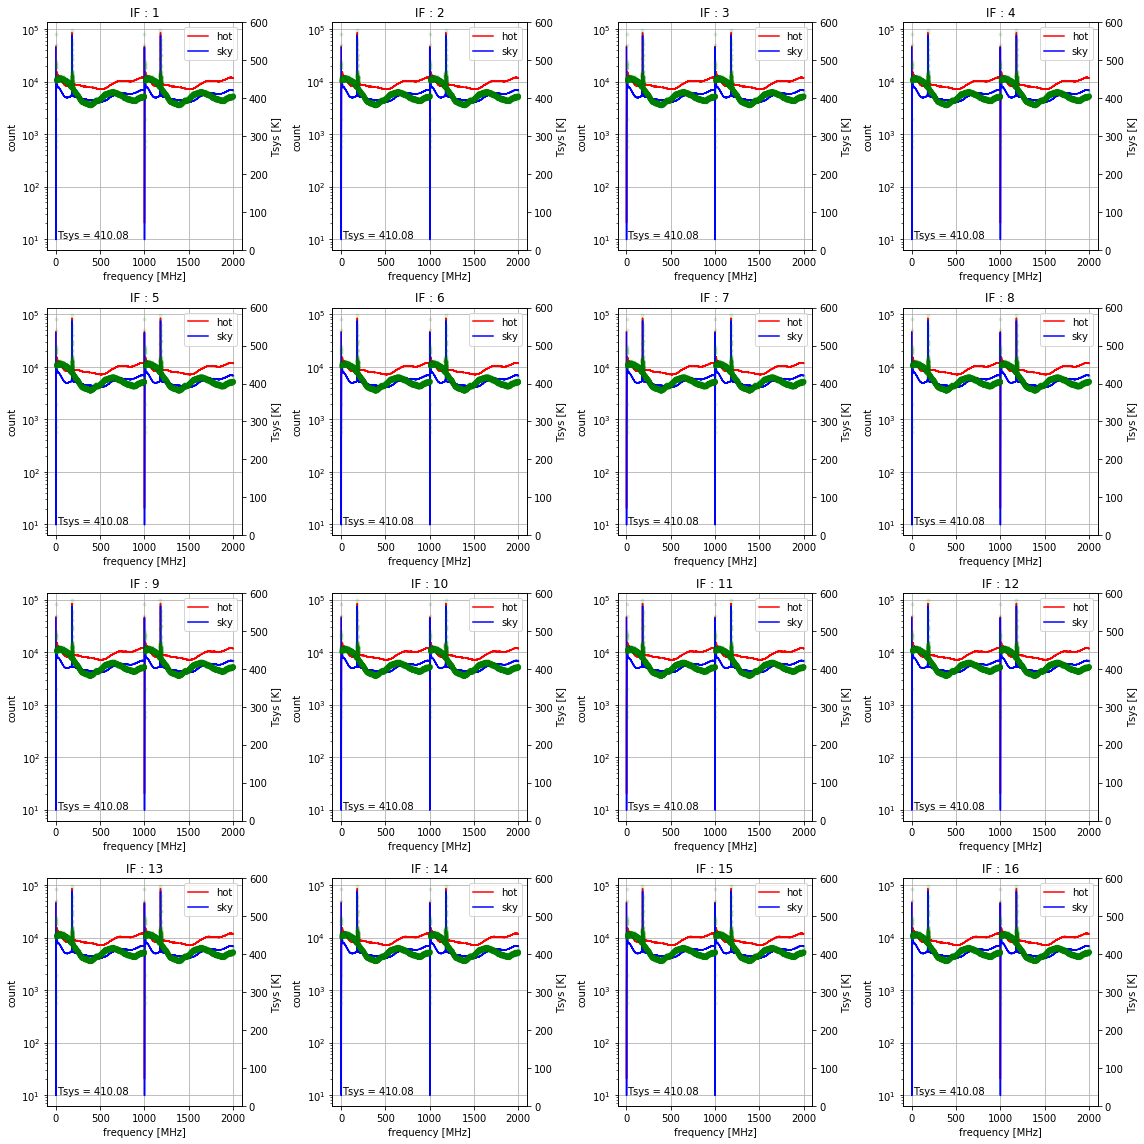

In [56]:
plt.tight_layout()
plt.savefig(os.path.join(os.path.dirname(path), "result_rsky.png"))
plt.show()